## Background information
Oil and gas reservoirs lie deep beneath the Earth's surface. Geologists and engineers cannot examine the rock formations in situ, so tools called sondes go there for them. Specialists lower these tools into a wellbore and obtain measurements of subsurface properties. The data are displayed as a series of measurements covering a depth range in a display called a well log. Often, several tools are run simultaneously as a logging string, and the combination of results is more informative than each individual measurement(https://www.slb.com/resource-library/oilfield-review/defining-series/defining-logging).

## Objective
Train a Machine Learning model to predict lithology using log measurements from two different geothermal wells.

## Data Source
https://gdr.openei.org/submissions/1111 

In [1]:
import graphviz
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
from platform import python_version

print('The Python version is {}.' .format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The Python version is 3.8.2.
The scikit-learn version is 0.23.2.


In [3]:
from sklearn import tree
from sklearn.datasets import *

We'll work with the Well_Data.csv. It has numerical value columns:

DENS: Density log
GR: Gamma ray log
SP: Spontaneous log
DEEP_RES: Deep Resistivity log
CAL: Caliper log

In [4]:
df = pd.read_csv('Well_Data.csv')
df.head()

,DENS,GR,SP,DEEP_RES,CAL,Lithology
0,2.5552,159.1349,82.500,1950.000,8.8111,Granitiod
1,2.0330,152.9230,-3.054,4.121,10.2130,Granitiod
2,2.5360,148.3970,3.369,2.099,14.7900,Granitiod
3,2.2640,154.8470,-2.059,1.265,12.4940,Granitiod
4,3.9170,72.0860,3.696,5.645,10.2000,Granitiod


In [5]:
df.describe()

,DENS,GR,SP,DEEP_RES,CAL
count,28584.000000,30399.000000,30410.000000,30410.000000,30410.000000
mean,2.642602,142.226313,19.129150,173.825669,10.136536
std,0.460718,54.432473,48.371447,382.208613,3.122901
min,1.656000,20.493500,-181.250000,0.272000,3.237500
25%,2.376000,99.365000,-0.565000,2.410000,8.883500
50%,2.556150,144.720000,3.194700,7.981850,10.186400
75%,2.660000,171.758600,47.500000,93.990850,12.463000
max,4.628800,641.089700,172.656300,1986.700000,16.580300


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30410 entries, 0 to 30409
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DENS       28584 non-null  float64
 1   GR         30399 non-null  float64
 2   SP         30410 non-null  float64
 3   DEEP_RES   30410 non-null  float64
 4   CAL        30410 non-null  float64
 5   Lithology  30410 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


## Clean Data
Delete rows with null value

In [7]:
df.isnull().sum()

DENS         1826
GR             11
SP              0
DEEP_RES        0
CAL             0
Lithology       0
dtype: int64

In [8]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28573 entries, 0 to 30409
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DENS       28573 non-null  float64
 1   GR         28573 non-null  float64
 2   SP         28573 non-null  float64
 3   DEEP_RES   28573 non-null  float64
 4   CAL        28573 non-null  float64
 5   Lithology  28573 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.5+ MB


In [9]:
df.isnull().sum()

DENS         0
GR           0
SP           0
DEEP_RES     0
CAL          0
Lithology    0
dtype: int64

## Data Visualization

In [10]:
df.columns

Index(['DENS', 'GR', 'SP', 'DEEP_RES', 'CAL', 'Lithology'], dtype='object')

<AxesSubplot:ylabel='Frequency'>

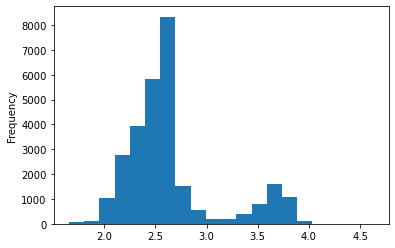

In [11]:
df['DENS'].plot(kind='hist', bins=20)

<AxesSubplot:ylabel='Frequency'>

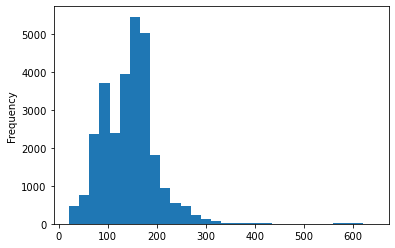

In [12]:
df['GR'].plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

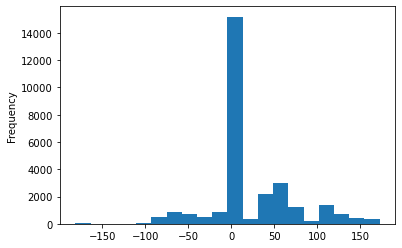

In [13]:
df['SP'].plot(kind='hist', bins=20)

<AxesSubplot:ylabel='Frequency'>

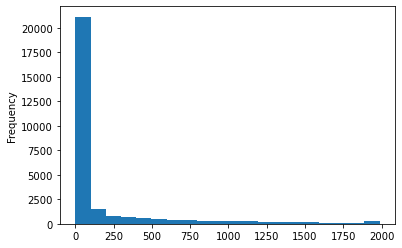

In [14]:
df['DEEP_RES'].plot(kind='hist', bins=20)

<AxesSubplot:ylabel='Frequency'>

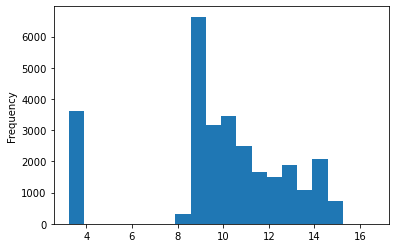

In [15]:
df['CAL'].plot(kind='hist', bins=20)

<AxesSubplot:>

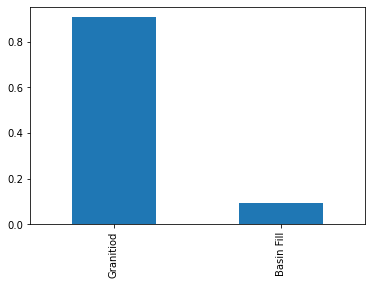

In [40]:
df['Lithology'].value_counts(normalize=True).plot(kind='bar')

#### Class Imbalance

In [41]:
df['Lithology'].value_counts(normalize=True)

Granitiod     0.907255
Basin Fill    0.092745
Name: Lithology, dtype: float64

In [42]:
df['Lithology'].value_counts()

Granitiod     25923
Basin Fill     2650
Name: Lithology, dtype: int64

In [82]:
x = df.drop('Lithology',axis=1) ## Lithology is the target values
y = df['Lithology']

### Address data imbalance by oversmaple Basin Fill class label and undersample Granitiod class label

In [49]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#### Undersample Granitiod class label

In [171]:
rus = RandomUnderSampler(sampling_strategy=0.2)
x_rus, y_rus = rus.fit_resample(x,y)

In [172]:
y_rus.value_counts()

Granitiod     13250
Basin Fill     2650
Name: Lithology, dtype: int64

#### Oversample Basin Fill class label

In [173]:
ros = RandomOverSampler(sampling_strategy=0.3)
x_ros, y_ros = ros.fit_resample(x_rus, y_rus)

In [174]:
y_ros.value_counts()

Granitiod     13250
Basin Fill     3975
Name: Lithology, dtype: int64

### Standardize
Standardize features by removing the mean and scaling to unit variance

In [95]:
from sklearn.preprocessing import StandardScaler

In [175]:
scaler = StandardScaler()
scaler.fit(x_ros)   
scaled_features = scaler.transform(x_ros)

In [176]:
x_std = pd.DataFrame(scaled_features,columns=x.columns)
x_std.head()

,DENS,GR,SP,DEEP_RES,CAL
0,-1.116734,-1.272912,0.597247,-0.370709,-1.695016
1,-1.050992,0.025286,-0.416779,-0.448877,1.217535
2,-0.965992,-0.914311,0.623680,0.158113,-1.695016
3,-0.649455,-0.924813,0.742628,-0.356517,-1.695016
4,-0.548960,-1.707529,1.006956,-0.114959,-1.681400


In [177]:
x_std.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17225 entries, 0 to 17224
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DENS      17225 non-null  float64
 1   GR        17225 non-null  float64
 2   SP        17225 non-null  float64
 3   DEEP_RES  17225 non-null  float64
 4   CAL       17225 non-null  float64
dtypes: float64(5)
memory usage: 673.0 KB


### Split training and testing data

In [178]:
from sklearn.model_selection import train_test_split

In [185]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y_ros, test_size=0.20, stratify = y_ros)

In [186]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13780 entries, 8473 to 16415
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DENS      13780 non-null  float64
 1   GR        13780 non-null  float64
 2   SP        13780 non-null  float64
 3   DEEP_RES  13780 non-null  float64
 4   CAL       13780 non-null  float64
dtypes: float64(5)
memory usage: 645.9 KB


In [187]:
y_train.value_counts()

Granitiod     10600
Basin Fill     3180
Name: Lithology, dtype: int64

In [188]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3445 entries, 6062 to 7182
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DENS      3445 non-null   float64
 1   GR        3445 non-null   float64
 2   SP        3445 non-null   float64
 3   DEEP_RES  3445 non-null   float64
 4   CAL       3445 non-null   float64
dtypes: float64(5)
memory usage: 161.5 KB


In [189]:
y_test.value_counts()

Granitiod     2650
Basin Fill     795
Name: Lithology, dtype: int64

## Data Training and Testing

## Training on Decision Tree

In [92]:
from sklearn import tree
from sklearn.datasets import *
from sklearn.metrics import classification_report,confusion_matrix

In [190]:
dtc_104 = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 10, min_samples_leaf = 4)
dtc_104_fit = dtc_104.fit(x_train, y_train)

### Visualizing Tree

In [63]:
x_features = x.columns.tolist()
y_target = y.unique().tolist()

In [191]:
text_representation = tree.export_text(dtc_104_fit, feature_names = x_features)
print(text_representation)

|--- GR <= -0.28
|   |--- DENS <= -0.00
|   |   |--- DEEP_RES <= -0.39
|   |   |   |--- DEEP_RES <= -0.45
|   |   |   |   |--- SP <= -0.48
|   |   |   |   |   |--- CAL <= 0.76
|   |   |   |   |   |   |--- class: Granitiod
|   |   |   |   |   |--- CAL >  0.76
|   |   |   |   |   |   |--- class: Basin Fill
|   |   |   |   |--- SP >  -0.48
|   |   |   |   |   |--- CAL <= 1.32
|   |   |   |   |   |   |--- DENS <= -0.44
|   |   |   |   |   |   |   |--- SP <= -0.44
|   |   |   |   |   |   |   |   |--- DENS <= -1.11
|   |   |   |   |   |   |   |   |   |--- class: Basin Fill
|   |   |   |   |   |   |   |   |--- DENS >  -1.11
|   |   |   |   |   |   |   |   |   |--- CAL <= 1.29
|   |   |   |   |   |   |   |   |   |   |--- class: Granitiod
|   |   |   |   |   |   |   |   |   |--- CAL >  1.29
|   |   |   |   |   |   |   |   |   |   |--- class: Basin Fill
|   |   |   |   |   |   |   |--- SP >  -0.44
|   |   |   |   |   |   |   |   |--- CAL <= 1.18
|   |   |   |   |   |   |   |   |   |--- class: Ba

In [192]:
fig = plt.figure(figsize = [100,80], dpi = 150)
ax = tree.plot_tree(dtc_104_fit, feature_names = x_features, class_names = y_target)
plt.show()

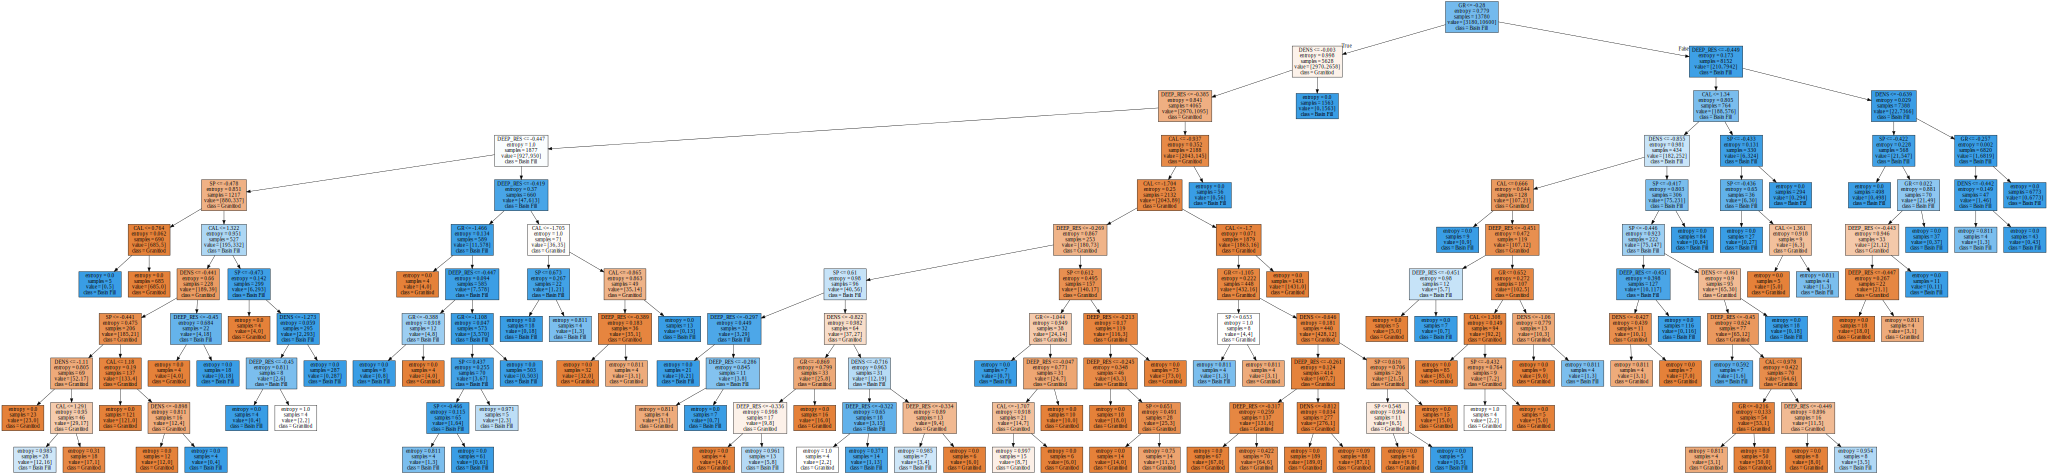

In [193]:
dot_data = tree.export_graphviz(dtc_104_fit, out_file=None, feature_names = x_features, class_names = y_target, filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

In [67]:
graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'

### Cross Validation

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [194]:
cv_results = cross_validate(dtc_104_fit, x_train, y_train, cv=5, scoring=['accuracy', 'precision_macro', 'precision_weighted', 'f1_macro', 'f1_weighted'])
cv_results

{'fit_time': array([0.05795383, 0.04841423, 0.04216671, 0.06014895, 0.04208469]),
 'score_time': array([0.08085418, 0.08894396, 0.09713411, 0.07659698, 0.07065701]),
 'test_accuracy': array([0.9894775 , 0.98766328, 0.9894775 , 0.9894775 , 0.98730044]),
 'test_precision_macro': array([0.98441006, 0.98418522, 0.98390259, 0.98144021, 0.98393469]),
 'test_precision_weighted': array([0.98949808, 0.98763538, 0.98951533, 0.98964333, 0.98726898]),
 'test_f1_macro': array([0.98520522, 0.98256811, 0.98522141, 0.98530154, 0.98204545]),
 'test_f1_weighted': array([0.98948616, 0.98764276, 0.98949189, 0.98952014, 0.98727576])}

### Testing Decision Tree on Test Data


In [195]:
y_dtc = dtc_104.predict(x_test)

In [196]:
print('max_depth = 10, min_samples_leaf = 4')
print('\n')
print(confusion_matrix(y_test,y_dtc))  ## TN: C00, FN: C10, TP: C11, FP: C01
print('\n')
print(classification_report(y_test,y_dtc))

max_depth = 10, min_samples_leaf = 4


[[ 782   13]
 [  20 2630]]


              precision    recall  f1-score   support

  Basin Fill       0.98      0.98      0.98       795
   Granitiod       1.00      0.99      0.99      2650

    accuracy                           0.99      3445
   macro avg       0.99      0.99      0.99      3445
weighted avg       0.99      0.99      0.99      3445



## Training and Testing on KNN

In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [204]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    y_knn = knn.predict(x_test)
    error_rate.append(np.mean(y_knn != y_test))

Text(0, 0.5, 'Error Rate')

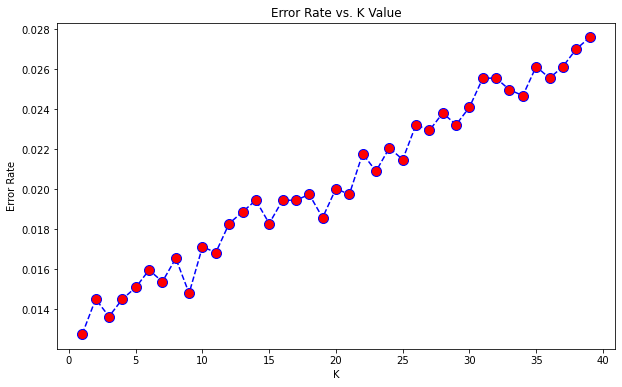

In [198]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [207]:
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(x_train,y_train)
y_knn_3 = knn_3.predict(x_test)

0.013642960812772133

In [202]:
print('Sample=0.8, K=3')
print('\n')
print(confusion_matrix(y_test,y_knn_3))
print('\n')
print(classification_report(y_test,y_knn_3))

Sample=0.8, K=3


[[ 780   15]
 [  32 2618]]


              precision    recall  f1-score   support

  Basin Fill       0.96      0.98      0.97       795
   Granitiod       0.99      0.99      0.99      2650

    accuracy                           0.99      3445
   macro avg       0.98      0.98      0.98      3445
weighted avg       0.99      0.99      0.99      3445

